In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
sns.set(style='white', context='notebook', palette='deep')

In [77]:
# 读入数据
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [78]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
del train
Y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

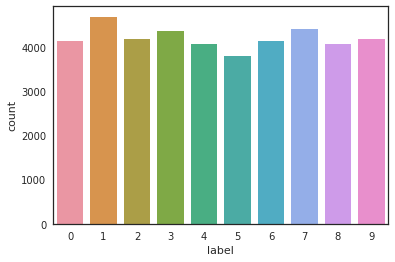

In [46]:
g = sns.countplot(Y_train)

In [33]:
print(Y_train.shape)
print(X_train.shape)

(37800, 10)
(37800, 28, 28, 1)


In [79]:
X_train = X_train / 255.0
test = test / 255.0
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [80]:
# 把 label 用一维向量表示 ：eg: 1 -> [0,1,0,0,0,0,0,0,0,0]
Y_train = to_categorical(Y_train, num_classes = 10)

In [81]:
random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [183]:
# CNN 网络结构为 : -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [184]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [215]:
epochs = 5
batch_size = 512

In [202]:
# 还不熟悉 ImageDataGenerator 参数使用的看这里：https://keras-cn.readthedocs.io/en/latest/preprocessing/image/
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # 图片旋转角度 (0 to 180)
        zoom_range = 0.1, # 随机缩放
        width_shift_range=0.1,  # 图片水平偏移的幅度(fraction of total width)
        height_shift_range=0.1,  # 图片竖值偏移的幅度 (fraction of total height)
        horizontal_flip=False,  # 水平反转
        vertical_flip=False)  # 竖直反转


datagen.fit(X_train)

In [216]:
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
 #         validation_data = (X_val, Y_val), verbose = 2)
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/5
 - 28s - loss: 0.0322 - acc: 0.9915 - val_loss: 0.0270 - val_acc: 0.9952
Epoch 2/5
 - 30s - loss: 0.0330 - acc: 0.9920 - val_loss: 0.0218 - val_acc: 0.9960
Epoch 3/5
 - 30s - loss: 0.0356 - acc: 0.9915 - val_loss: 0.0178 - val_acc: 0.9952
Epoch 4/5
 - 29s - loss: 0.0288 - acc: 0.9921 - val_loss: 0.0174 - val_acc: 0.9948
Epoch 5/5
 - 30s - loss: 0.0291 - acc: 0.9922 - val_loss: 0.0216 - val_acc: 0.9955


In [105]:
results = model.predict(test)
# 挑选出最大的概率
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [106]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)

In [221]:
!ls ../Jupyter

cnn_mnist_datagen.csv  pre.csv		      test.zip	     Untitled1.ipynb
datas.ipynb	       pred.csv		      train	     Untitled2.ipynb
gap_InceptionV3.h5     sample_submission.csv  train2	     Untitled3.ipynb
gap_ResNet50.h5        submission.csv	      train.csv      Untitled4.ipynb
gap_VGG16.h5	       test		      training_data  Untitled5.ipynb
gap_VGG19.h5	       test2		      train.ipynb    Untitled.ipynb
gap_Xception.h5        test.csv		      train.zip
